<a href="https://colab.research.google.com/github/deveshusg/credit-risk-portfolio/blob/main/notebooks/01_through_the_cycle_pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧮 Through-The-Cycle Probability of Default (TTC PD) Model  
### Dataset: Give Me Some Credit (Kaggle)  
**Objective:**  
To build a *through-the-cycle* probability of default model that estimates a borrower’s *average creditworthiness* independent of short-term macroeconomic volatility.  

**Dataset summary:**  
We use the “Give Me Some Credit” dataset (~150k observations) containing anonymized borrower credit and demographic variables, with the binary target `SeriousDlqin2yrs` indicating whether the borrower experienced a 90+ DPD (days past due) event in the next two years.

**Business context:**  
- **Point-in-Time (PIT)** PDs vary with the economic cycle — e.g., more defaults during recessions.  
- **Through-the-Cycle (TTC)** PDs reflect *average risk over a full cycle*, removing short-term cyclicality.  
This TTC model will form a foundation for:
- IFRS9 and Basel-compliant credit risk modeling
- Expected credit loss (ECL) calculations
- Capital adequacy modeling and stress testing  

**Notebook stages:**
1. Data loading and initial exploration  
2. Detailed EDA (distribution, correlation, multicollinearity, outliers, stability)  
3. Feature engineering and transformation  
4. Model development (logistic regression baseline → calibrated TTC PD)  
5. Model testing and validation  
6. Output interpretation and TTC adjustments  


In [6]:
# --- Why ---
# This block loads the required Python libraries and the Give Me Some Credit dataset.
# The dataset is small enough (~7MB) to load directly from disk, so no sampling or chunking is needed.
# Using pandas for data handling, numpy for numerical operations, matplotlib & seaborn for visualization,
# and sklearn for later modeling stages.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid", palette="muted")
# --- Mount repo in Colab ---
import os

# Clone your GitHub repo if not already present
if not os.path.exists("credit-risk-portfolio"):
    !git clone https://github.com/deveshusg/credit-risk-portfolio.git

# Set working directory
os.chdir("credit-risk-portfolio")

# Confirm
print("Current working directory:", os.getcwd())
!ls data/raw/GiveMeSomeCredit



# Load dataset
DATA_PATH = "data/raw/GiveMeSomeCredit/cs-training.csv"
df = pd.read_csv(DATA_PATH)

# Inspect basic shape and head
print("Shape of dataset:", df.shape)
df.head()


Cloning into 'credit-risk-portfolio'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 73 (delta 12), reused 37 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 5.10 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Current working directory: /content/credit-risk-portfolio/credit-risk-portfolio/credit-risk-portfolio
blank  cs-test.csv  cs-training.csv  sampleEntry.csv
Shape of dataset: (150000, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
# --- Why ---
# This cell inspects key metadata about the dataset:
# - column types
# - missingness
# - unique values
# - basic descriptive statistics
# These help identify data quality issues and variable types.

# --- Alternatives ---
# df.info() gives concise summaries but no numeric detail; df.describe(include='all') gives everything but is verbose.
# Combining both gives the most complete overview.

print("=== Dataset Info ===")
df.info()

print("\n=== Missing Values (Count & %) ===")
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean() * 100).sort_values(ascending=False)
pd.DataFrame({"Missing Count": missing_summary, "Missing %": missing_pct}).head(10)


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 no

,Missing Count,Missing %
MonthlyIncome,29731,19.820667
NumberOfDependents,3924,2.616000
Unnamed: 0,0,0.000000
SeriousDlqin2yrs,0,0.000000
age,0,0.000000
RevolvingUtilizationOfUnsecuredLines,0,0.000000
DebtRatio,0,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0,0.000000
NumberOfOpenCreditLinesAndLoans,0,0.000000
NumberOfTimes90DaysLate,0,0.000000


In [8]:
# --- Numeric summary statistics ---
# This gives distribution metrics, range, and spread for all numeric variables.
# Helps detect potential scale issues and outliers.

df.describe().T


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64


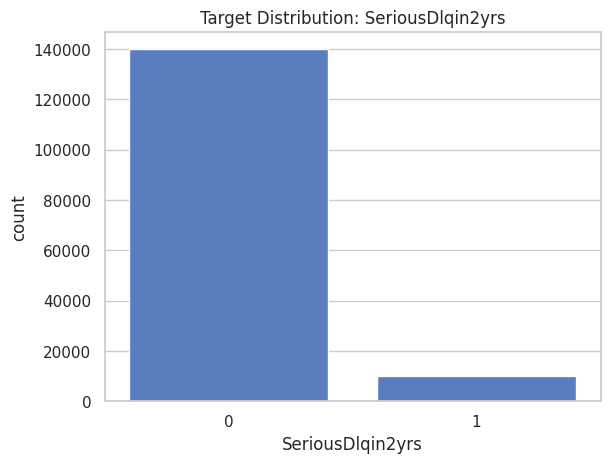

In [9]:
# --- Why ---
# Understanding the class distribution (defaults vs non-defaults) is crucial.
# Default datasets are usually imbalanced — which affects model training and metrics.
# In TTC modeling, we expect to model *average default risk*, so we retain natural imbalance but monitor it.

target = 'SeriousDlqin2yrs'
print(df[target].value_counts(normalize=True))
sns.countplot(x=target, data=df)
plt.title("Target Distribution: SeriousDlqin2yrs")
plt.show()


Only ~6.68% of customers defaulted (SeriousDlqin2yrs=1).
This means the dataset is highly imbalanced, and care must be taken when choosing model metrics (e.g., AUC, KS instead of accuracy).

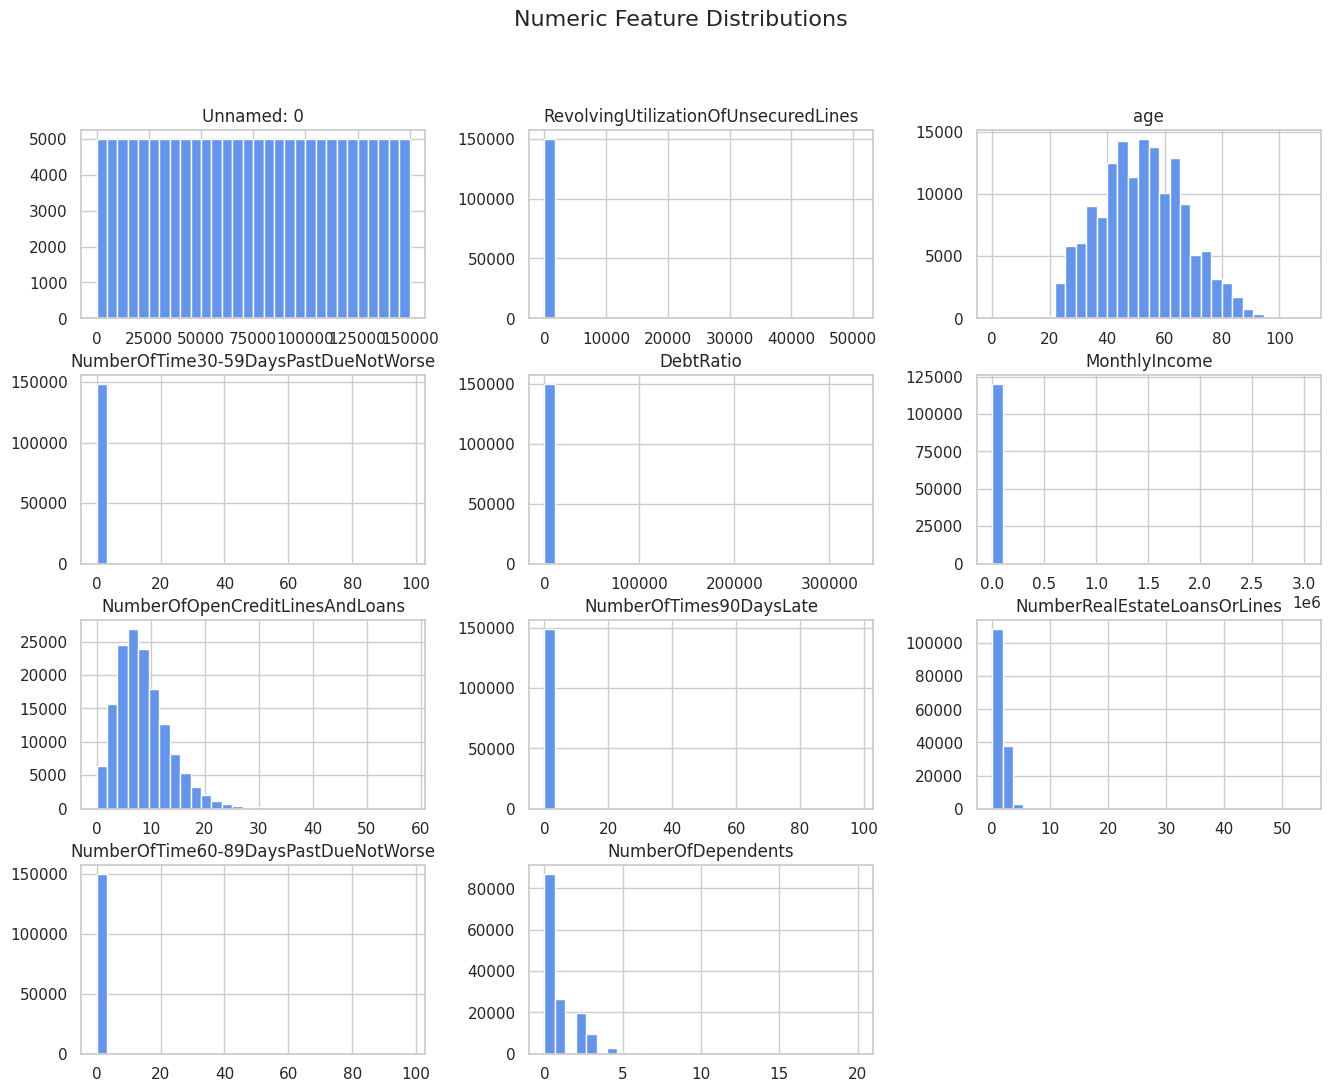

In [15]:
# --- Why ---
# Visualize the shape (normal, skewed, bimodal) of numeric predictors.
# Skewed distributions often require log or quantile transformations for stability.

num_cols = df.select_dtypes(include=[np.number]).columns.drop(target)
df[num_cols].hist(bins=30, figsize=(16, 12), color='cornflowerblue')
plt.suptitle("Numeric Feature Distributions", fontsize=16)
plt.show()
